# RNN Training

From our paper on "Explainable Prediction of Acute Myocardial Infarction using Machine Learning and Shapley Values"

In [ ]:
# Import libraries
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Layer, GRU, LSTM, Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from keras.layers import LeakyReLU
from keras import regularizers, backend, initializers
from keras.models import Sequential
from keras.utils import to_categorical
import keras.backend as K
from keras.initializers import Ones, Zeros

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn import preprocessing
from sklearn import metrics

import time
import gc

import pandas as pd
import numpy as np
import pylab as plt
import tensorflow as tf
from numpy import loadtxt
from numpy import savetxt
from tensorflow.python.framework import ops
print(tf.__version__)

# Visualization Libraries
import seaborn as sns

# Size of matplotlib histogram bins
bin_size = 20

# Loading Data

In [ ]:
# Load data
train = loadtxt('train.csv', delimiter=',')
test = loadtxt('test.csv', delimiter=',')

# Split array
train_x = train[:,:11]
test_x = test[:,:11]
train_y = train[:,11]
test_y = test[:,11]

In [12]:
# Check the new distribution in the training and testing sets
unique, counts = np.unique(train_y, return_counts=True)
dict(zip(unique, counts))

{0.0: 281967, 1.0: 141064}

In [13]:
unique, counts = np.unique(test_y, return_counts=True)
dict(zip(unique, counts))

{0.0: 70559, 1.0: 35199}

# Model Definition + Training

In [14]:
start = time.clock() 

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

layer_size1 = 12
layer_size2 = 10
layer_size3 = 7
layer_size4 = 5
layer_size5 = 4
layer_size6 = 3
timesteps = 1 # static data
data_dim = 11

X_train = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
X_test = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
train_y = to_categorical(train_y)

model = Sequential()
model.add(GRU(layer_size1, return_sequences=True, input_shape=(timesteps, data_dim)))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(GRU(layer_size2, return_sequences=True))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(GRU(layer_size3, return_sequences=True))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(GRU(layer_size4, return_sequences=True))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(GRU(layer_size5, return_sequences=True))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(GRU(layer_size6, return_sequences=False))
model.add(LayerNormalization())
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(2, activation='softmax'))


opt = optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Set early stopping based on accuracy. It stops after 10 consecutive epochs of no accuracy improvement.
early = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

# Reduce learning rate based on accuracy. It reduces the rate after 7 consecutive epochs of no accuracy improvement.
redonplat = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=7, verbose=0)

callbacks_list = [early, redonplat]

# Train the model
history = model.fit(X_train, train_y, epochs=1000, verbose=0, callbacks=callbacks_list, validation_split=0.1)
end = time.clock()
print("Time for training: {} ".format((end-start))) 

# Save the model
model.save("rnn_ecgview.h5")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Epoch 00046: early stopping
Time for training: 4402.126376 


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


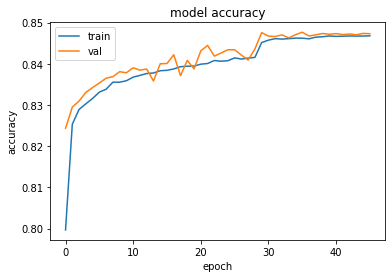

In [16]:
# Plot model accuracy evolution
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

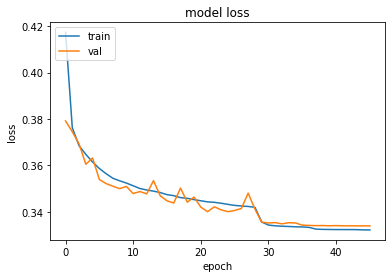

In [17]:
# Plot model loss evolution
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()